<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Translation_System_LSTM_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Installing Libraries

!pip install nltk
!pip install gensim
!pip install spacy
!pip install plotly

import nltk
nltk.download('plunkt')

[nltk_data] Error loading plunkt: Package 'plunkt' not found in index


False

In [42]:
# Importing the Libraries and Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import operator
import plotly.express as px

# NLP Libraries
import nltk
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional

In [43]:
# Mounting the Collab Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Importing the Dataset

df_english = pd.read_csv('/content/drive/My Drive/Projects/English French Translator: Long Short Term Memory Networks/small_vocab_en.csv', sep= "\t", names= ["english"])
df_french = pd.read_csv('/content/drive/My Drive/Projects/English French Translator: Long Short Term Memory Networks/small_vocab_fr.csv', sep= "\t", names= ["french"])

In [45]:
# Validating the Data

display(df_english.head())
df_french.head()

,english
0,"new jersey is sometimes quiet during autumn , ..."
1,the united states is usually chilly during jul...
2,"california is usually quiet during march , and..."
3,the united states is sometimes mild during jun...
4,"your least liked fruit is the grape , but my l..."


,french
0,new jersey est parfois calme pendant l' automn...
1,les états-unis est généralement froid en juill...
2,"california est généralement calme en mars , et..."
3,"les états-unis est parfois légère en juin , et..."
4,"votre moins aimé fruit est le raisin , mais mo..."


In [46]:
# Check the Info for both
print(df_english.info())
df_french.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   french  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [47]:
# Concatenate English and French Data Together
df = pd.concat([df_english, df_french], axis= 1) # 1 for New Column
df.head()

,english,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


In [48]:
print(f"The Total English Records are {len(df['english'])}, and the Total French Records are {len(df['french'])}")

The Total English Records are 137860, and the Total French Records are 137860


In [49]:
# Data Cleaning

# Downloading the NLP Packages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
# Creating Function to Remove Punctuations
def remove_punct(text):
    return re.sub('[!#?,.:";]', '', text)

In [51]:
# Apply the Function to Data

df['english'] = df['english'].apply(remove_punct)
df['french'] = df['french'].apply(remove_punct)

In [52]:
# Identify Unique Words in English and French Dictionary
english_words, french_words = [], []

def get_unique_words(text, word_list):
    for word in text.split():
        if word not in word_list:
            word_list.append(word)

# Apply the Function to get the Unique Words Present
df['english'].apply(lambda x: get_unique_words(x, english_words))
df['french'].apply(lambda x: get_unique_words(x, french_words))

# Get the Total words -> Used for creating Model Architecture
total_english_words = len(english_words)
total_french_words = len(french_words)

print("The Total unique words in English is {} and Total unique words in French is {}".format(len(english_words), len(french_words)))

The Total unique words in English is 199 and Total unique words in French is 350


In [53]:
# Get the Total Unique Words

def get_label_superset(x, word_list):
    for label in x.split():
        if label not in word_list:
            word_list

In [54]:
# Visualizing the Cleaned Up Dataset

# For English Documents

# Obtaining list of all words in the dataset
words = []
for obs in df['english']:
    for word in obs.split():
        words.append(word)

words[:10]

['new',
 'jersey',
 'is',
 'sometimes',
 'quiet',
 'during',
 'autumn',
 'and',
 'it',
 'is']

In [55]:
# Obtaining the Counts of the Words
english_word_counts = Counter(words) # Get a counter of Word and Frequency

# Sort the Dictionary by Values
english_word_counts = sorted(english_word_counts.items(), key= operator.itemgetter(1), reverse= True)

english_word_counts[:10]

[('is', 205858),
 ('in', 75525),
 ('it', 75137),
 ('during', 74933),
 ('the', 67628),
 ('but', 63987),
 ('and', 59850),
 ('sometimes', 37746),
 ('usually', 37507),
 ('never', 37500)]

In [56]:
# Get the words and frequency in Seperate List -> Useful to plot Histogram
english_words, english_counts = [], []

for i in range(len(english_word_counts)):
    english_words.append(english_word_counts[i][0])
    english_counts.append(english_word_counts[i][1])

In [57]:
# Plot the Histogram
fig = px.bar(x= english_words, y= english_counts)
fig.show();

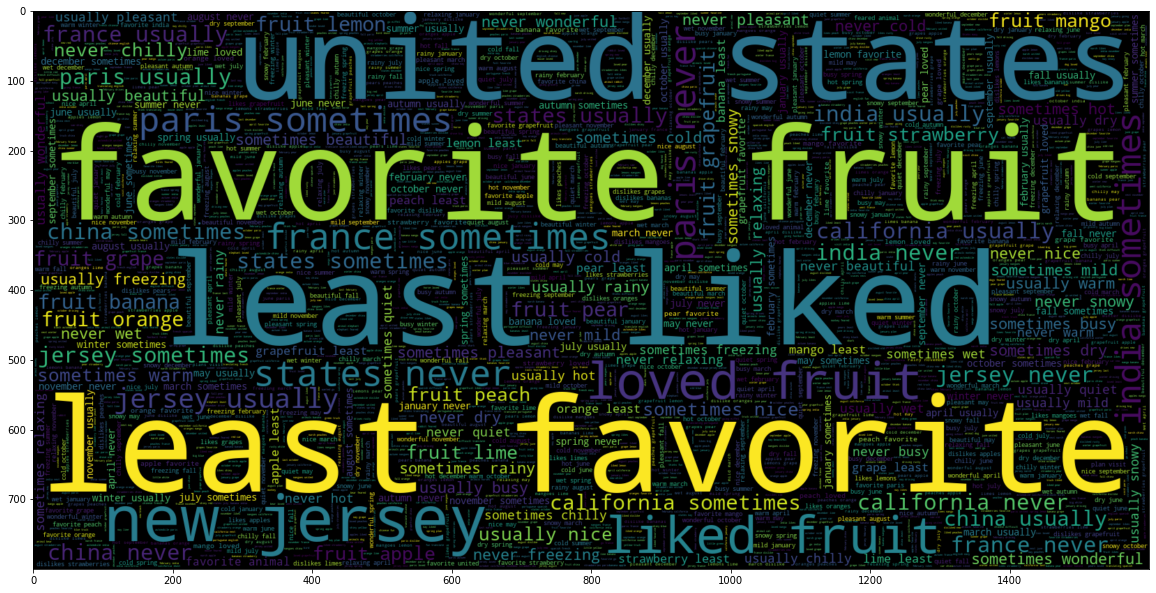

In [58]:
# Plot the Wordcloud for the Text

plt.figure(figsize= (20, 16))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df['english']))
plt.imshow(wc, interpolation= 'bilinear');

In [59]:
# Get the Maximum Length of words in a Document

maxlen_english = -1

for doc in df['english']:
    tokens = nltk.word_tokenize(doc)
    if maxlen_english < len(tokens):
        maxlen_english = len(tokens)

print(f"The Maximum No.of Words in any English Documents is {maxlen_english}")

The Maximum No.of Words in any English Documents is 15


In [60]:
# Validate the Tokenisation
print("The Sample Record in English is: ", df['english'][0])
print("The Tokenised Version of the Above is: ", nltk.word_tokenize(df['english'][0]))

The Sample Record in English is:  new jersey is sometimes quiet during autumn  and it is snowy in april 
The Tokenised Version of the Above is:  ['new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn', 'and', 'it', 'is', 'snowy', 'in', 'april']


In [61]:
# Visualizing the Cleaned Up Dataset

# For French Documents

# Obtaining list of all words in the dataset
words_fr = []
for obs in df['french']:
    for word in obs.split():
        words_fr.append(word)

words_fr[:10]

['new',
 'jersey',
 'est',
 'parfois',
 'calme',
 'pendant',
 "l'",
 'automne',
 'et',
 'il']

In [62]:
# Obtaining the Counts of the Words
french_word_counts = Counter(words_fr) # Get a counter of Word and Frequency

# Sort the Dictionary by Values
french_word_counts = sorted(french_word_counts.items(), key= operator.itemgetter(1), reverse= True)

french_word_counts[:10]

[('est', 196809),
 ('en', 105768),
 ('il', 84079),
 ('les', 65255),
 ('mais', 63987),
 ('et', 59851),
 ('la', 49861),
 ('parfois', 37746),
 ('jamais', 37215),
 ('le', 35306)]

In [63]:
# Get the words and frequency in Seperate List -> Useful to plot Histogram
french_words, french_counts = [], []

for i in range(len(french_word_counts)):
    french_words.append(french_word_counts[i][0])
    french_counts.append(french_word_counts[i][1])

# Plot the Histogram
fig = px.bar(x= french_words, y= french_counts)
fig.show();

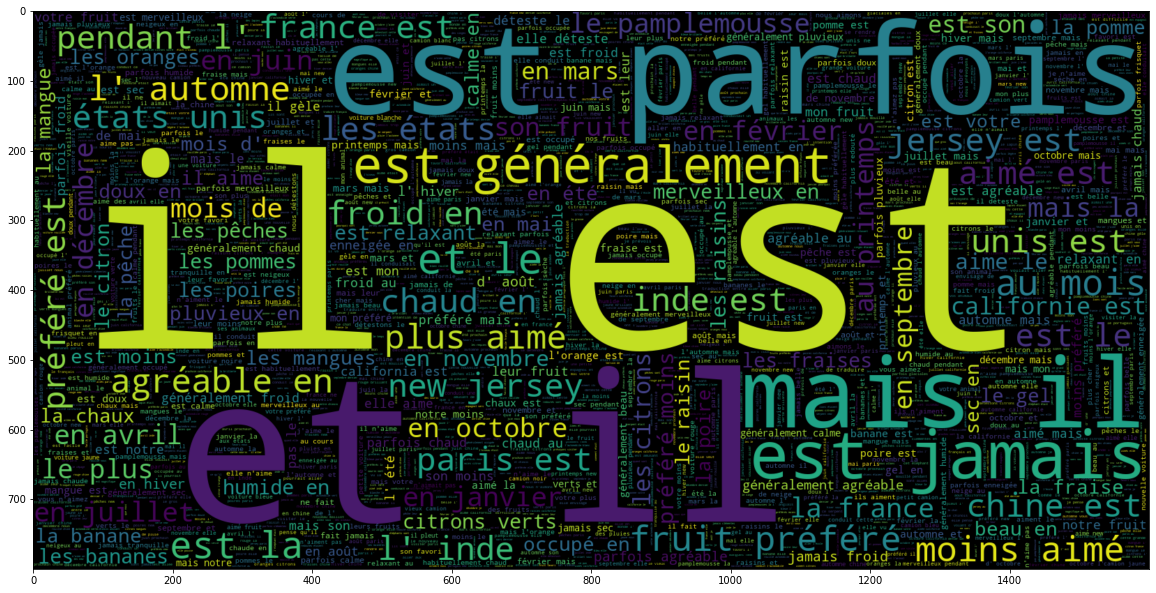

In [64]:
# Plot the Wordcloud for the Text

plt.figure(figsize= (20, 16))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df['french']))
plt.imshow(wc, interpolation= 'bilinear');

In [65]:
# Get the Maximum Length of words in a Document

maxlen_french = -1

for doc in df['french']:
    tokens = nltk.word_tokenize(doc)
    if maxlen_french < len(tokens):
        maxlen_french = len(tokens)

print(f"The Maximum No.of Words in any French Documents is {maxlen_french}")

The Maximum No.of Words in any French Documents is 23


In [66]:
# Validate the Tokenisation
print("The Sample Record in French is: ", df['french'][0])
print("The Tokenised Version of the Above is: ", nltk.word_tokenize(df['french'][0]))

The Sample Record in French is:  new jersey est parfois calme pendant l' automne  et il est neigeux en avril 
The Tokenised Version of the Above is:  ['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', 'l', "'", 'automne', 'et', 'il', 'est', 'neigeux', 'en', 'avril']


In [67]:
# Prepare the Data by Performing Tokenisation and Padding

# Converting the Text Data to Tokens (Vectorize Text corpus to a Sequence of Integers)

# Create a Function to Identify the Max Word and pad it

def tokenize_and_pad(x, maxlen):
    tokenizer = Tokenizer(char_level= False) # Only Words and Not Charecters
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences, maxlen= maxlen, padding= 'post') # Increase of Maxlen may lead to Overfitting/Skewed Data
    return tokenizer, sequences, padded

In [68]:
# Tokenize and Pad the Data by Applying the Function

X_tokenizer, X_sequences, X_padded = tokenize_and_pad(df['english'], maxlen_french) # We go for the Larger Padded Sequence Length (23)
y_tokenizer, y_sequences, y_padded = tokenize_and_pad(df['french'], maxlen_french)

# Validation

print("The Tokenized Version for the Document: \n {} is: \n {}".format(df['english'][-1:].item(), X_padded[-1:]))
print("The Tokenized Version for the Document: \n {} is: \n {}".format(df['french'][-1:].item(), y_padded[-1:]))

The Tokenized Version for the Document: 
 the orange is her favorite fruit  but the banana is your favorite  is: 
 [[ 5 84  1 32 11 13  6  5 87  1 29 11  0  0  0  0  0  0  0  0  0  0  0]]
The Tokenized Version for the Document: 
 l'orange est son fruit préféré  mais la banane est votre favori  is: 
 [[84  1 20 16 17  5  7 87  1 40 93  0  0  0  0  0  0  0  0  0  0  0  0]]


In [69]:
# Applying Machine Learning Methods

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size= 0.1)

print(f"The Shape of Training Set is {X_train.shape, y_train.shape} and the Test Set is {X_test.shape, y_test.shape}")

The Shape of Training Set is ((124074, 23), (124074, 23)) and the Test Set is ((13786, 23), (13786, 23))


In [81]:
# Building and Training a LSTM-RNN Network

# Seq2Seq:- English Word -> Embedding Layer -> [Encoder] (LSTM) -> [Decoder] (Repeat Vector -> LSTM) -> TimeDistributed (Dense) -> French Word

# Model Building
english_vocab_size = total_english_words + 1
french_vocab_size = total_french_words + 1

# Model Architecture

model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim= english_vocab_size, output_dim= 512, input_length= maxlen_english, mask_zero= True)) # Masked is for Sparse vectors. Old Units were 256

# Encoder
model.add(LSTM(units= 512))

# Decoder
model.add(RepeatVector(n= maxlen_french))
# The Repeat Vector repeats the Inputs for a desired number of times to change 2D Array to 3D Array
model.add(LSTM(units= 512, return_sequences= True))

# TimeDistributed
model.add(TimeDistributed(Dense(units= french_vocab_size, activation= 'softmax')))

# Compiling the Mode;
model.compile(optimizer= 'adam', loss= "sparse_categorical_crossentropy", metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 512)           102400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 23, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 23, 512)           2099200   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 23, 351)           180063    
Total params: 4,480,863
Trainable params: 4,480,863
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Change shape of y from 2D to 3D

y_train = np.expand_dims(y_train, axis= 2)
y_train.shape, X_train.shape

((124074, 23, 1), (124074, 23))

In [82]:
# Model Training
model.fit(X_train, y_train, batch_size= 1024, validation_split= 0.1, epochs= 30)

Epoch 1/30
110/110 [==============================] - 47s 430ms/step - loss: 2.5289 - accuracy: 0.5043 - val_loss: 1.8026 - val_accuracy: 0.5777
Epoch 2/30
110/110 [==============================] - 46s 419ms/step - loss: 1.5881 - accuracy: 0.6026 - val_loss: 1.4447 - val_accuracy: 0.6290
Epoch 3/30
110/110 [==============================] - 46s 421ms/step - loss: 1.2673 - accuracy: 0.6589 - val_loss: 1.1241 - val_accuracy: 0.6837
Epoch 4/30
110/110 [==============================] - 46s 421ms/step - loss: 1.0106 - accuracy: 0.7129 - val_loss: 0.9283 - val_accuracy: 0.7345
Epoch 5/30
110/110 [==============================] - 46s 421ms/step - loss: 0.8577 - accuracy: 0.7464 - val_loss: 0.7956 - val_accuracy: 0.7595
Epoch 6/30
110/110 [==============================] - 46s 419ms/step - loss: 0.7238 - accuracy: 0.7846 - val_loss: 0.6869 - val_accuracy: 0.7935
Epoch 7/30
110/110 [==============================] - 46s 420ms/step - loss: 0.6075 - accuracy: 0.8197 - val_loss: 0.5867 - val_ac

In [83]:
# Saving the Model

model.save('en_fr_30epochs.h5')

In [84]:
# Assess the Trained Model Performance

y_predict = model.predict(X_test)
print("The Shape of Y_Predict is: ", y_predict.shape)

The Shape of Y_Predict is:  (13786, 23, 351)


In [85]:
# Define a Function to Make Predictions

def predictor(x, x_tokenizer= X_tokenizer, y_tokenizer= y_tokenizer):
    predictions = model.predict(x)[0]
    # Change Dictionary
    id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
    id_to_word[0] = ''
    return ' '.join( [id_to_word[j] for j in np.argmax(predictions, axis=1)] )

# Define a Function to Pad to the text

def pad_to_text(padded, tokenizer):
    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = ""
    return ' '.join( [id_to_word[j] for j in padded])

In [86]:
# Predict the Value

for i in range(5):
    print("Original English Words: {}\n".format(pad_to_text(X_test[i], X_tokenizer)))
    print("Original French Words: {}\n".format(pad_to_text(y_test[i], y_tokenizer)))
    print("Predicted French Words are: {}\n\n".format(predictor(x= X_test[i: i+1])))

Original English Words: the united states is rainy during september and it is never wonderful in november         

Original French Words: les états unis est pluvieux en septembre et il est jamais merveilleux en novembre         

Predicted French Words are: les états unis est pluvieux en septembre et il est jamais merveilleux en novembre         


Original English Words: new jersey is warm during february but it is usually nice in march          

Original French Words: new jersey est chaud au mois de février mais il est généralement agréable en mars        

Predicted French Words are: new jersey est chaud au mois de février mais il est généralement agréable en mars        


Original English Words: she was driving a little yellow automobile                

Original French Words: elle conduisait une petite voiture jaune                 

Predicted French Words are: elle conduisait une petite voiture jaune                 


Original English Words: the united states is quiet during 